In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import collections
import pickle as pkl

import arviz as az
from haplm.gp_util import SphereGneiting
import pytensor.tensor as pt

from matplotlib import rc, rcParams
rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex = True) # uncomment if no LaTeX setup
rc('font', size=14)

# colors for plotting
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

In [2]:
cv_rng = np.random.default_rng(7337) # seed for random subsetting for cross validation
cv_tot = 10

with open('processed.pkl', 'rb') as fp:
    data = pkl.load(fp)
    ys = data['ys']
    ns = np.array(data['ns'])
    amats = data['amats']
    codes = data['codes']
    infos = data['infos']
    X = data['X']
    lm_list = data['lm_list']


N = len(ys)
H = 8
G = 3
    
# handle CV split
rand_idx = np.arange(N)
cv_rng.shuffle(rand_idx)

In [3]:
idata = az.from_netcdf('../../data/dhps/exact.netcdf')

ls_s = np.median(np.vstack(idata.posterior['ls_s']))
ls_t = np.median(np.vstack(idata.posterior['ls_t']))
cov_func = SphereGneiting(ls_s, ls_t)

C = cov_func(X, X).eval()

In [4]:
pred_by_fold = [np.load(f'../../data/dhps/exact_pred_samples_cv{fold+1}.npy') for fold in range(cv_tot)]

In [5]:
# convert ternary array to binary array (rows of A)
def t2b(tarr):
    G = len(tarr)
    H = 1 << G
    pos = sum(1 << j for j in range(G) if tarr[j] == 1)
    neg = sum(1 << j for j in range(G) if tarr[j] == 0)
    barr = np.zeros(H,int)
    for i in range(H):
        if (pos & i == pos) and not (neg & i):
            barr[i] = 1
    return barr

In [6]:
wt_alleles = 'AKA'
mut_alleles = 'GEG'
locs = ['437', '540', '581']
def fcode_to_name(fcode):
    tokens = []
    for i, val in enumerate(fcode):
        if val == 1:
            tokens.append(locs[i]+mut_alleles[i])
        elif val == 0:
            tokens.append(wt_alleles[i]+locs[i])
    return '-'.join(tokens)

In [7]:
res_by_fcode = collections.defaultdict(list)
nn_measure = np.zeros(N)

i = 0
for f, pred_samples in enumerate(pred_by_fold):
    for i_in_fold in range(pred_samples.shape[1]):
        idx = rand_idx[i]
        i += 1
        
        codevec = codes[idx]
        info = infos[idx]
        # -1 corresponds to no info
        full_codemat = -1 * np.ones((len(codevec), G), int)
    
        j = 0
        for mut, reports_mut in enumerate(info):
            if not reports_mut:
                continue
            full_codemat[:,mut] = [code[j] for code in codevec]
            j += 1
        
        amat = np.array([t2b(code) for code in full_codemat])
        pred_median = np.median(pred_samples[:,i_in_fold] @ amat.T, axis=0)
        
        for fcode, m, y in zip(full_codemat, pred_median, ys[idx]):
            res_by_fcode[tuple(fcode)].append((idx, m, y))
            
        test_start = int(N * (f / cv_tot))
        test_end = int(N * ((f+1) / cv_tot))
        train_idx = rand_idx[list(range(test_start)) + list(range(test_end, N))]
        nn_measure[idx] = C[idx, train_idx].max()

In [8]:
min(nn_measure), max(nn_measure)

(0.23783271581909146, 1.0)

437G 208
Mean error         :  0.0389
Mean absolute error:  0.1158
540E 214
Mean error         :  0.0096
Mean absolute error:  0.0731
581G 154
Mean error         : -0.0302
Mean absolute error:  0.0553
437G-540E 63
Mean error         : -0.0060
Mean absolute error:  0.0451
437G-540E-581G 35
Mean error         : -0.0518
Mean absolute error:  0.0778
437G-540E-A581 33
Mean error         : -0.0150
Mean absolute error:  0.0758


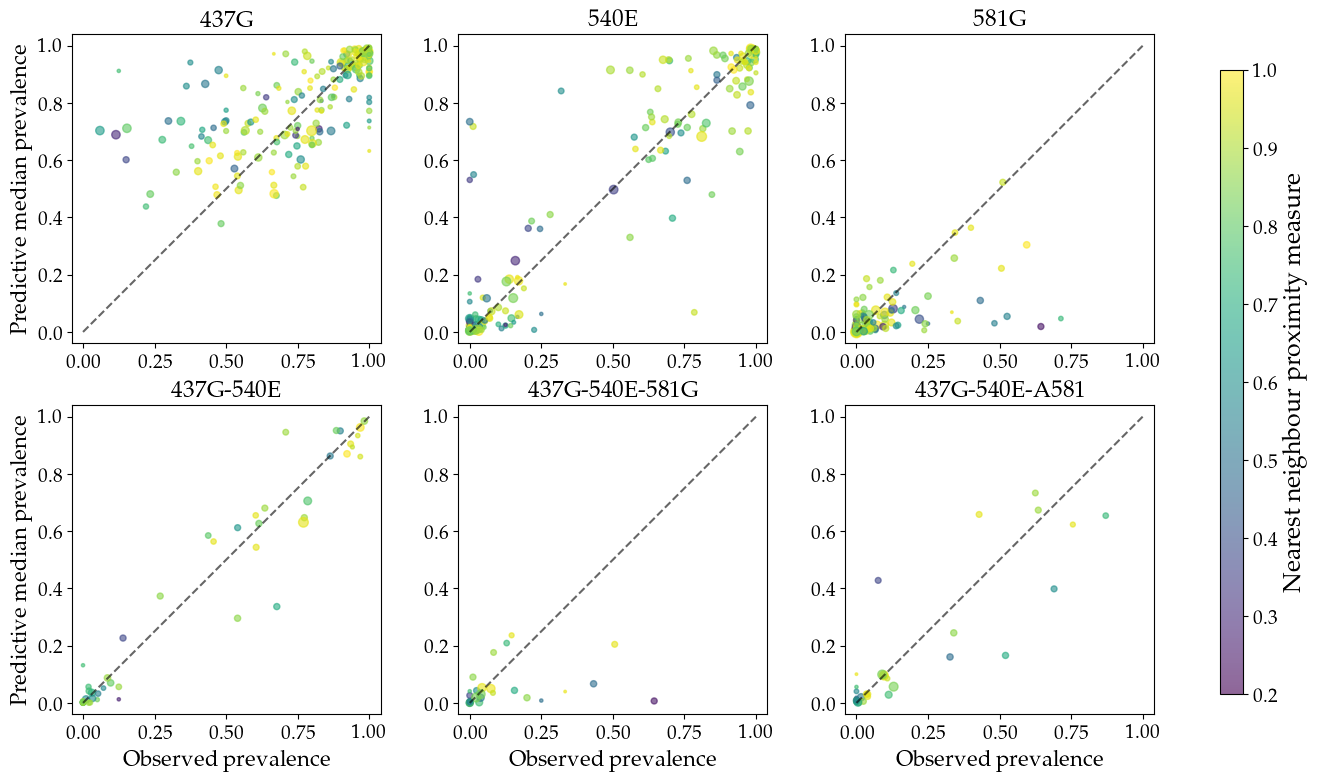

In [9]:
def fcode_order(fcode):
    name = fcode_to_name(fcode)
    return (len(name), name)

fcodes_ordered = sorted(res_by_fcode.keys(), key=fcode_order)

fig, axes = plt.subplots(figsize=(15, 8), ncols=3, nrows=2)
fig.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.85, wspace=0.1, hspace=0.2)

for r, fcode in enumerate(fcodes_ordered):
    idxs, m, y = map(np.array, zip(*res_by_fcode[fcode]))
    n = ns[idxs]
    ax = axes[r//3,r%3]
    sc = ax.scatter(y/n, m, alpha=0.6, s=2*np.sqrt(n), c=nn_measure[idxs], vmin=0.2, vmax=1)
    ax.plot([0,1], [0,1], '--', color='k', alpha=0.6)
    ax.set_title(fcode_to_name(fcode))
    
    ax.set_xlim(-0.04,1.04)
    ax.set_ylim(-0.04,1.04)    
    if r//3 == 1:
        ax.set_xlabel('Observed prevalence', fontsize=16)
    if r%3 == 0:
        ax.set_ylabel('Predictive median prevalence', fontsize=16)
    ax.set_aspect('equal')
    
    print(fcode_to_name(fcode), len(y))
    # print(f'Pearson correlation: {np.corrcoef(y/n, m)[0,1]:7.4f}')
    print(f'Mean error         : {np.mean(m-y/n):7.4f}')
    print(f'Mean absolute error: {np.mean(np.abs(m-y/n)):7.4f}')

sm =  cm.ScalarMappable(norm=mcolors.Normalize(vmin=0.2, vmax=1), cmap=plt.get_cmap("viridis"))
sm.set_array([])
cbar_ax = fig.add_axes([0.88, 0.125, 0.015, 0.78])
cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.6)
cbar.set_alpha(0.6)
cbar.set_label("Nearest neighbour proximity measure", fontsize=18);
plt.savefig('validation.png', dpi=300, facecolor='white');